In [27]:
import numpy as np
import json
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from itertools import combinations 
import matplotlib.transforms
import random
import math
import pandas as pd
import networkx as nx

import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModel

import spacy
from spacy.symbols import ORTH

from scipy.stats import ks_2samp
import statistics

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from copy import deepcopy

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Dataset preprocessing

### Loading BERT

In [2]:
model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Preparing text for BERT (coherent and not coherent)

In [88]:
utts = [] #utterances to extract to build non coherent dialogues
lengths = [] #number of utterances per dialogue to extract to build non coherent dialogues

#preparing input for attention extraction
lst_dict = [] #list of dict instances containing BERT preprocessed text and plain text
with open('./data/EMNLP_dataset/dialogues_text.txt', 'r') as f:
    lines = f.readlines()
    for l in tqdm(lines):
        bert_tokenized = bert_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        if len(bert_tokenized) < 513:
            lst_dict.append({'bert': "[CLS] " + l.replace("__eou__", "[SEP]").replace("\n", "").replace("'", " ' "), 
                             'txt': l.replace("\n", "").replace("'", " ' ")})
            
            utts += [utt.strip() for utt in lst_dict[-1]['bert'][5:].split("[SEP]") if (utt.strip() not in ["", " "])]
            lengths.append(lst_dict[-1]['bert'].count("[SEP]"))

#preparing non coherent dialogues
dialogues = ""
utts_list = random.sample(utts, len(utts)) #random permutation over utterances

#preparing text for non coherent dialogues
d_iterator = 0
for i in tqdm(np.arange(len(lengths))):
    dialogue_length = lengths[i]
    dialogue = ""
    for _ in np.arange(dialogue_length):
        dialogue += utts_list[d_iterator] + "__eou__"
        d_iterator += 1
    dialogues += dialogue +"\n"

#saving non coherent dialogues
with open('./data/EMNLP_dataset/dialogues_text_not_coherent.txt', 'w') as f:
    f.write(dialogues)
    
#preparing for attention extraction - non coherent dialogues
lst_dict_not_coherent = []
with open('./data/EMNLP_dataset/dialogues_text_not_coherent.txt', 'r') as f:
    lines = f.readlines()
    for l in tqdm(lines):
        bert_tokenized = bert_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        if len(bert_tokenized) < 513:
            lst_dict_not_coherent.append({'bert': "[CLS] " + l.replace("__eou__", "[SEP]").replace("\n", "").replace("'", " ' "),
                             'txt': l.replace("\n", "").replace("'", " ' ")})

100%|██████████| 13086/13086 [00:04<00:00, 2741.75it/s]


In [90]:
lst_dict[0]

{'bert': "[CLS] The kitchen stinks . [SEP] I ' ll throw out the garbage . [SEP]",
 'txt': "The kitchen stinks . __eou__ I ' ll throw out the garbage . __eou__"}

### Extracting attentions

In [111]:
def from_torch_tensor2_numpy(tensor):
    arr = np.empty((len(tensor), tensor[0].size()[1], tensor[0].size()[-1], tensor[0].size()[-1]))
    for i, item in enumerate(tensor):
        arr[i] = item[0].cpu().detach().numpy()
    return arr

#translate BERT tokens into spacy tokens and performs alignments
def from_tkn_to_spacy(dict_txt, tokenizer, model_type):
    txt = dict_txt['txt']
    tkn_spacy, tkn_spacy_aligned = [], ["[CLS]"] if  model_type == 'bert' else []
    head_spacy, head_spacy_aligned = [], [None] if  model_type == 'bert' else []
    word_spacy, word_spacy_aligned =  [], ["[CLS]"] if  model_type == 'bert' else []
    pos_spacy, pos_spacy_aligned =  [], ["[CLS]"] if  model_type == 'bert' else []
    for utt in txt.split("__eou__"):
        doc = nlp(utt)
        for tkn in doc:
            if tkn.text.strip() !="":
                tokenized = tokenizer.convert_ids_to_tokens(tokenizer.encode(tkn.text, return_tensors = 'pt', add_special_tokens = False)[0])
                for t in tokenized:
                    if t[:2] != "##":
                        tkn_spacy.append(tkn.dep_)
                        head_spacy.append(tkn.head.i)
                        word_spacy.append(tkn.text)
                        pos_spacy.append(tkn.pos_)
                    tkn_spacy_aligned.append(tkn.dep_)
                    head_spacy_aligned.append(tkn.head.i)
                    word_spacy_aligned.append(tkn.text)
                    pos_spacy_aligned.append(tkn.pos_)
        
        tkn_spacy_aligned.append("[SEP]")
        word_spacy_aligned.append("[SEP]")
        head_spacy_aligned.append("[SEP]")
        pos_spacy_aligned.append("[SEP]")
    
    tkn_spacy = tkn_spacy[:-1] if model_type == 'bert' else tkn_spacy
    tkn_spacy_aligned = tkn_spacy_aligned[:-1] if model_type == 'bert' else tkn_spacy_aligned
    word_spacy_aligned = word_spacy_aligned[:-1] if model_type == 'bert' else word_spacy_aligned
    head_spacy_aligned = head_spacy_aligned[:-1] if model_type == 'bert' else head_spacy_aligned
    pos_spacy_aligned = pos_spacy_aligned[:-1] if model_type == 'bert' else pos_spacy_aligned
    return tkn_spacy, word_spacy, head_spacy, pos_spacy, tkn_spacy_aligned, word_spacy_aligned, head_spacy_aligned, pos_spacy_aligned

#spacy initialization
nlp = spacy.load("en_core_web_sm")
special_case = [{ORTH: "gonna"}]
nlp.tokenizer.add_special_case("gonna", special_case)
special_case = [{ORTH: "gotta"}]
nlp.tokenizer.add_special_case("gotta", special_case)
special_case = [{ORTH: "cannot"}]
nlp.tokenizer.add_special_case("cannot", special_case)

#primary data structures to save attentions
models = ['bert'] #ready to be extended
keys = [('bert', bert_tokenizer, 'bert', bert_model)]
attention_dicts = {
    k: [] for k in models
}
attention_dicts_not_coherent = {
    k: [] for k in models
}

In [112]:
#to run if there is not something saved
for k, tokenizer, model_type, model in keys:
    for item in tqdm(lst_dict[:300]):
        inputs = tokenizer.encode(item[model_type], 
                                return_tensors = 'pt', 
                                add_special_tokens = False)
        outputs = model(inputs)
        deps, w, h, pos, deps_a, w_a, h_a, pos_a = from_tkn_to_spacy(item, tokenizer, model_type)
        attention_dicts[k].append({'attns' : from_torch_tensor2_numpy(outputs[-1]),
                                'tokens' : tokenizer.convert_ids_to_tokens(inputs[0]),
                                'relns': deps,
                                'words': w,
                                'heads': h,
                                'pos' : pos,
                                'relns_aligned':deps_a,
                                'words_aligned': w_a,
                                'heads_aligned': h_a,
                                'pos_aligned' : pos_a})

#save
for k in attention_dicts:
    output = open(f'./data/data_attention_annotated{k}.pkl', 'wb')
    pickle.dump(attention_dicts[k], output)
    output.close()

100%|██████████| 300/300 [00:25<00:00, 11.70it/s]


In [113]:
#to run if there is not something saved
for k, tokenizer, model_type, model in keys:
    for item in tqdm(lst_dict_not_coherent[:300]):
        inputs = tokenizer.encode(item[model_type], 
                                return_tensors = 'pt', 
                                add_special_tokens = False)
        outputs = model(inputs)
        deps, w, h, pos, deps_a, w_a, h_a, pos_a = from_tkn_to_spacy(item, tokenizer, model_type)
        attention_dicts_not_coherent[k].append({'attns' : from_torch_tensor2_numpy(outputs[-1]),
                                'tokens' : tokenizer.convert_ids_to_tokens(inputs[0]),
                                'relns': deps,
                                'words': w,
                                'heads': h,
                                'pos' : pos,
                                'relns_aligned':deps_a,
                                'words_aligned': w_a,
                                'heads_aligned': h_a,
                                'pos_aligned' : pos_a})

#save
for k in tqdm(attention_dicts_not_coherent):
    output = open(f'./data/data_attention_annotated_not_coherent{k}.pkl', 'wb')
    pickle.dump(attention_dicts_not_coherent[k], output)
    output.close()

100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


## Attention analysis

### Loading model and data

In [2]:
model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
def data_iterator(data):
  for i, doc in enumerate(data):
    if i % 100 == 0 or i == len(data) - 1:
      print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
    yield doc["tokens"], np.array(doc["attns"]), doc["words"], doc["relns"], doc["heads"], doc["pos"], doc["relns_aligned"], doc["words_aligned"], doc["heads_aligned"], doc["pos_aligned"]
    
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

In [4]:
#primary data structures to save attentions
models = ['bert'] #ready to be extended
keys = [('bert', bert_tokenizer, 'bert', bert_model)]
attention_dicts = {
    k: [] for k in models
}
attention_dicts_not_coherent = {
    k: [] for k in models
}

for k in attention_dicts:
    attention_dicts[k] = load_pickle(f'./data/data_attention_annotated{k}.pkl')
    
for k in attention_dicts_not_coherent:
    attention_dicts_not_coherent[k] = load_pickle(f'./data/data_attention_annotated_not_coherent{k}.pkl')

In [115]:
dep_keys = np.unique([k for attn_dict in attention_dicts for example in attention_dicts[attn_dict] for k in example['relns_aligned'] if k not in ["[SEP]", "[CLS]", "punct"]])
pos_keys = np.unique([k for attn_dict in attention_dicts for example in attention_dicts[attn_dict] for k in example['pos_aligned']])
positional_keys = np.array(["self", "right", "left", "sep_sep","rest_sep", "ALL", "utt_with_current", "utt_without_current", "no_cls_sep_punct"])
special_tkns = np.concatenate((dep_keys, pos_keys, positional_keys))

### Aggregating attention (with or without filters)

In [86]:
def compute_avg_attn_fake(attn_dict):
  avg_attns = {
      k: np.zeros((12, 12)) for k in special_tkns
  }

  avg_attention_dicts = {
      k: avg_attns.copy() for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  distribution_attentions_dicts = {
    k: {m : [] for m in special_tkns} for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  pointwise_distribution_attentions_dicts = {
    k: [[{'lower':[], 'upper':[]} for _ in np.arange(12)] for _ in np.arange(12)] for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  for k in avg_attention_dicts:
      data = attn_dict[k]
      n_docs = len(attn_dict[k])
      
      n_elem = 0
      print("Computing token stats")
      for tokens, attns, _, _, _, _, relns_aligned, words_aligned, _, pos_aligned  in data_iterator(data):
        n_tokens = tf.shape(attns)[-1]
        print(tokens)
        #check if alignment is correct
        if n_tokens != len(relns_aligned):
          print(f"Not aligned n. {n_elem}")
          print(relns_aligned[-1])
          for i in np.arange(len(relns_aligned)):
            print(tokens[i], words_aligned[i], relns_aligned[i])
          return
        
        n_elem+=1
        #sentence filters
        sep_positions = [i for i, item in enumerate(tokens) if item in ['[CLS]', '[SEP]']]
        utt_masks_with_current = []
        utt_masks_without_current = []
        for i in np.arange(len(sep_positions)-1):
          mask_with_current = np.zeros(shape = (n_tokens, n_tokens))
          mask_without_current = np.zeros(shape = (n_tokens, n_tokens))
          for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
              #xor: !=; to avoid attentions to current utterance
              #or: or; to integrate attentions to current utterance
              mask_with_current[v][w] = 1 if (((v >= sep_positions[i] and v <= sep_positions[i+1]) or (w >= sep_positions[i] and w <= sep_positions[i+1]))
                                   and pos_aligned[w] != 'PUNCT' and tokens[w] not in ['[SEP]', '[CLS]']
                                   and pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]']) else 0
              mask_without_current[v][w] = 1 if ((v >= sep_positions[i] and v <= sep_positions[i+1]) != (w >= sep_positions[i] and w <= sep_positions[i+1]) 
                                   and pos_aligned[w] != 'PUNCT' and tokens[w] not in ['[SEP]', '[CLS]']
                                   and pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]']) else 0
          utt_masks_with_current.append(mask_with_current)
          utt_masks_without_current.append(mask_without_current)
          
        # no cls, sep and punct filter
        mask_no_cls_sep_punct = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
              mask_no_cls_sep_punct[v][w] = 1 if (pos_aligned[w] != 'PUNCT' and tokens[w] not in ['[SEP]', '[CLS]']
              and pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]']) else 0
        
        #filter for particular tokens: create masks indicating where particular tokens are
        masks_relns = {
          m: np.array([1 if r == m else 0 for r in relns_aligned]) for m in dep_keys
        }
        
        masks_pos = {
          m: np.array([1 if r == m else 0 for r in pos_aligned]) for m in pos_keys
        }
        
        masks = masks_relns | masks_pos 

        seps = masks['[SEP]']
        # create masks indicating which positions are relevant for each key
        sep_seps = np.ones((n_tokens, n_tokens))
        sep_seps *= seps[np.newaxis]
        sep_seps *= seps[:, np.newaxis]

        rest_seps = np.ones((n_tokens, n_tokens))
        rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
        rest_seps *= seps[np.newaxis]
        
        selectors = {
          m: np.tile(masks[m][np.newaxis], [n_tokens, 1]) for m in masks
        }
        
        selectors = selectors | {
          # Return a 2-D array with ones on the diagonal and zeros elsewhere.
            "self": np.eye(n_tokens, n_tokens),
            "right": np.eye(n_tokens, n_tokens, 1),
            "left": np.eye(n_tokens, n_tokens, -1),
          # Construct an array by repeating A the number of times given by reps. n_tokens arrays having one seps[np.newaxis] repetition each
            "sep_sep": sep_seps,
            "rest_sep": rest_seps,
            "ALL" : np.ones(shape=(n_tokens,n_tokens)),
            "utt_with_current": utt_masks_with_current,
            "utt_without_current": utt_masks_without_current,
            "no_cls_sep_punct": mask_no_cls_sep_punct
        }
        
        return selectors, tokens

In [87]:
s, t = compute_avg_attn_fake(attention_dicts)

Computing token stats
0.3% done
['[CLS]', 'the', 'kitchen', 'stink', '##s', '.', '[SEP]', 'i', "'", 'll', 'throw', 'out', 'the', 'garbage', '.', '[SEP]']


In [93]:
cols = t
a = s['no_cls_sep_punct'].astype(int)
df = pd.DataFrame(a, columns=cols, index=cols)
print(df)

         [CLS]  the  kitchen  stink  ##s  .  [SEP]  i  '  ll  throw  out  the  \
[CLS]        0    0        0      0    0  0      0  0  0   0      0    0    0   
the          0    1        1      1    1  0      0  1  0   1      1    1    1   
kitchen      0    1        1      1    1  0      0  1  0   1      1    1    1   
stink        0    1        1      1    1  0      0  1  0   1      1    1    1   
##s          0    1        1      1    1  0      0  1  0   1      1    1    1   
.            0    0        0      0    0  0      0  0  0   0      0    0    0   
[SEP]        0    0        0      0    0  0      0  0  0   0      0    0    0   
i            0    1        1      1    1  0      0  1  0   1      1    1    1   
'            0    0        0      0    0  0      0  0  0   0      0    0    0   
ll           0    1        1      1    1  0      0  1  0   1      1    1    1   
throw        0    1        1      1    1  0      0  1  0   1      1    1    1   
out          0    1        1

In [744]:
def compute_avg_attn(attn_dict):
  avg_attns = {
      k: np.zeros((12, 12)) for k in special_tkns
  }

  avg_attention_dicts = {
      k: avg_attns.copy() for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  distribution_attentions_dicts = {
    k: {m : [] for m in special_tkns} for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  pointwise_distribution_attentions_dicts = {
    k: [[{'lower':[], 'upper':[]} for _ in np.arange(12)] for _ in np.arange(12)] for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  for k in avg_attention_dicts:
      data = attn_dict[k]
      n_docs = len(attn_dict[k])
      
      n_elem = 0
      print("Computing token stats")
      for tokens, attns, _, _, _, _, relns_aligned, words_aligned, _, pos_aligned  in data_iterator(data):
        n_tokens = tf.shape(attns)[-1]
        
        #check if alignment is correct
        if n_tokens != len(relns_aligned):
          print(f"Not aligned n. {n_elem}")
          print(relns_aligned[-1])
          for i in np.arange(len(relns_aligned)):
            print(tokens[i], words_aligned[i], relns_aligned[i])
          return
        
        n_elem+=1
        #sentence filters
        sep_positions = [i for i, item in enumerate(tokens) if item in ['[CLS]', '[SEP]']]
        utt_masks_with_current = []
        utt_masks_without_current = []
        for i in np.arange(len(sep_positions)-1):
          mask_with_current = np.zeros(shape = (n_tokens, n_tokens))
          mask_without_current = np.zeros(shape = (n_tokens, n_tokens))
          for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
              #xor: !=; to avoid attentions to current utterance
              #or: or; to integrate attentions to current utterance
              mask_with_current[v][w] = 1 if (((v >= sep_positions[i] and v <= sep_positions[i+1]) or (w >= sep_positions[i] and w <= sep_positions[i+1]))
                                   and pos_aligned[w] != 'PUNCT' and tokens[w] not in ['[SEP]', '[CLS]']
                                   and pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]']) else 0
              mask_without_current[v][w] = 1 if ((v >= sep_positions[i] and v <= sep_positions[i+1]) != (w >= sep_positions[i] and w <= sep_positions[i+1]) 
                                   and pos_aligned[w] != 'PUNCT' and tokens[w] not in ['[SEP]', '[CLS]']
                                   and pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]']) else 0
          utt_masks_with_current.append(mask_with_current)
          utt_masks_without_current.append(mask_without_current)
          
        # no cls, sep and punct filter
        mask_no_cls_sep_punct = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
              mask_no_cls_sep_punct[v][w] = 1 if (pos_aligned[w] != 'PUNCT' and tokens[w] not in ['[SEP]', '[CLS]']
              and pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]']) else 0
        
        #filter for particular tokens: create masks indicating where particular tokens are
        masks_relns = {
          m: np.array([1 if r == m else 0 for r in relns_aligned]) for m in dep_keys
        }
        
        masks_pos = {
          m: np.array([1 if r == m else 0 for r in pos_aligned]) for m in pos_keys
        }
        
        masks = masks_relns | masks_pos 

        seps = masks['[SEP]']
        # create masks indicating which positions are relevant for each key
        sep_seps = np.ones((n_tokens, n_tokens))
        sep_seps *= seps[np.newaxis]
        sep_seps *= seps[:, np.newaxis]

        rest_seps = np.ones((n_tokens, n_tokens))
        rest_seps *= (np.ones(n_tokens) - seps)[:, np.newaxis]
        rest_seps *= seps[np.newaxis]
        
        selectors = {
          m: np.tile(masks[m][np.newaxis], [n_tokens, 1]) for m in masks
        }
        
        selectors = selectors | {
          # Return a 2-D array with ones on the diagonal and zeros elsewhere.
            "self": np.eye(n_tokens, n_tokens),
            "right": np.eye(n_tokens, n_tokens, 1),
            "left": np.eye(n_tokens, n_tokens, -1),
          # Construct an array by repeating A the number of times given by reps. n_tokens arrays having one seps[np.newaxis] repetition each
            "sep_sep": sep_seps,
            "rest_sep": rest_seps,
            "ALL" : np.ones(shape=(n_tokens,n_tokens)),
            "utt_with_current": utt_masks_with_current,
            "utt_without_current": utt_masks_without_current,
            "no_cls_sep_punct": mask_no_cls_sep_punct
        }
        
        # get the average attention for each token type
        n_tok = n_tokens ** 2
        for key, selector in selectors.items():
          if key in ['utt_with_current', 'utt_without_current']:
            #get the average attention for each token belonging/not belonging to the current utterance
            total_attn = np.zeros(shape = (12, 12))
            for utt in selector:
              denom = utt.sum(-1).sum(-1)
              #media delle attenzioni esterne
              total_attn += ((attns * utt[np.newaxis, np.newaxis]).sum(-1).sum(-1)) / (denom*len(selector))
          else:
            denom = selector.sum(-1).sum(-1)
            if(denom == 0):
              denom = 1
            total_attn = (
              (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) / denom)
          
          #media delle medie
          avg_attention_dicts[k][key] += total_attn/n_docs
          #distribuzione delle medie
          distribution_attentions_dicts[k][key].append(total_attn)
          
        print(f"Computing pointwise attention {n_elem}", end='\r')
        for l in np.arange(12):
          for h in np.arange(12):
            m = (attns * selectors["ALL"][np.newaxis, np.newaxis])[l][h]
            pointwise_distribution_attentions_dicts[k][l][h]['lower'].append(np.quantile(m,0.9))
            pointwise_distribution_attentions_dicts[k][l][h]['upper'].append(np.quantile(m,1))
          
  return avg_attention_dicts, distribution_attentions_dicts, pointwise_distribution_attentions_dicts

In [745]:
avg_attention_dicts, distrib_attention_dicts, pointwise_distrib_attention_dicts = compute_avg_attn(attention_dicts)
for k in tqdm(avg_attention_dicts):
    output = open(f'./data/avg_attention_dicts{k}.pkl', 'wb')
    pickle.dump(avg_attention_dicts[k], output)
    output.close()
    output = open(f'./data/distrib_attention_dicts{k}.pkl', 'wb')
    pickle.dump(distrib_attention_dicts[k], output)
    output.close()
    output = open(f'./data/pointwise_distrib_attention_dicts{k}.pkl', 'wb')
    pickle.dump(pointwise_distrib_attention_dicts[k], output)
    output.close()

Computing token stats
0.3% done
33.7% donepointwise attention 100
67.0% donepointwise attention 200
100.0% doneointwise attention 299


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


In [746]:
avg_attention_not_coherent_dicts, distrib_attention_not_coherent_dicts, pointwise_distrib_attention_not_coherent_dicts = compute_avg_attn(attention_dicts_not_coherent)
for k in tqdm(avg_attention_not_coherent_dicts):
    output = open(f'./data/avg_attention_not_coherent_dicts{k}.pkl', 'wb')
    pickle.dump(avg_attention_not_coherent_dicts[k], output)
    output.close()
    output = open(f'./data/distrib_attention_not_coherent_dicts{k}.pkl', 'wb')
    pickle.dump(distrib_attention_not_coherent_dicts[k], output)
    output.close()
    output = open(f'./data/pointwise_distrib_attention_not_coherent_dicts{k}.pkl', 'wb')
    pickle.dump(pointwise_distrib_attention_not_coherent_dicts[k], output)
    output.close()

Computing token stats
0.3% done
33.7% donepointwise attention 100
67.0% donepointwise attention 200
100.0% doneointwise attention 299


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


### Analysing aggregated attention

#### Loading attentions

In [6]:
avg_attns = {k: np.zeros((12, 12)) for k in special_tkns}
avg_attention_dicts = {k: avg_attns.copy() for k in attention_dicts.keys() if attention_dicts[k] != []}
distrib_attention_dicts = {k: {m : [] for m in special_tkns} for k in attention_dicts.keys() if attention_dicts[k] != []}
pointwise_distrib_attention_dicts = {k: [[{'lower':[], 'upper':[]} for _ in np.arange(12)] for _ in np.arange(12)] for k in attention_dicts.keys() if attention_dicts[k] != []}

for k in attention_dicts:
    avg_attention_dicts[k] = load_pickle(f'./data/avg_attention_dicts{k}.pkl')
    distrib_attention_dicts[k] = load_pickle(f'./data/distrib_attention_dicts{k}.pkl')
    pointwise_distrib_attention_dicts[k] = load_pickle(f'./data/pointwise_distrib_attention_dicts{k}.pkl')

avg_attention_not_coherent_dicts = {k: avg_attns.copy() for k in attention_dicts_not_coherent.keys() if attention_dicts_not_coherent[k] != []}
distrib_attention_not_coherent_dicts = {k: {m : [] for m in special_tkns} for k in attention_dicts_not_coherent.keys() if attention_dicts_not_coherent[k] != []}
pointwise_distrib_attention_not_coherent_dicts = {k: [[{'lower':[], 'upper':[]} for _ in np.arange(12)] for _ in np.arange(12)] for k in attention_dicts.keys() if attention_dicts[k] != []}

for k in attention_dicts_not_coherent:
    avg_attention_not_coherent_dicts[k] = load_pickle(f'./data/avg_attention_not_coherent_dicts{k}.pkl')
    distrib_attention_not_coherent_dicts[k] = load_pickle(f'./data/distrib_attention_not_coherent_dicts{k}.pkl')
    pointwise_distrib_attention_not_coherent_dicts[k] = load_pickle(f'./data/pointwise_distrib_attention_not_coherent_dicts{k}.pkl')

#### Plots

In [112]:
def plot_avg_matrices(attn_dict, model_name, diffs = False):
    #magenta -> negativo
    #verde -> positivo
    #bianco -> 0
    n_elem = (10 * (int(len(special_tkns)/10) + 1)) if len(special_tkns)%10 !=0 else (10 * (int(len(special_tkns)/10)))
    n_row = int(n_elem/5)
    n_col = 5
    fig, ax = plt.subplots(n_row, n_col, figsize=(20,70))
    plt.set_cmap('PiYG')
    fig.suptitle(model_name, fontsize=16)
    
    I, J = np.unravel_index(np.arange(n_elem), shape = (n_row, n_col))
    for k, t in enumerate([k for k in pos_keys if k not in ["[SEP]", "[CLS]"]]):
        i, j = I[k], J[k]
        if diffs:
            d = np.round(np.sum(np.sum(np.absolute(attn_dict[t]), axis = -1), axis = -1), 4)
            ax[i][j].set_title(f"{t}; Diff: {d}")
        else:
            ax[i][j].set_title(f"{t}")
        ax[i][j].set_xlabel("Heads")
        ax[i][j].set_ylabel("Layers")
        ax[i][j].set_xticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        ax[i][j].set_yticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        # apply offset transform to all x ticklabels.
        # Create offset transform by 5 points in x direction
        dx = -8/72.; dy = 0/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].xaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        
        dx = 0/72.; dy = 8/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].yaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        ax[i][j].imshow(attn_dict[t])
        

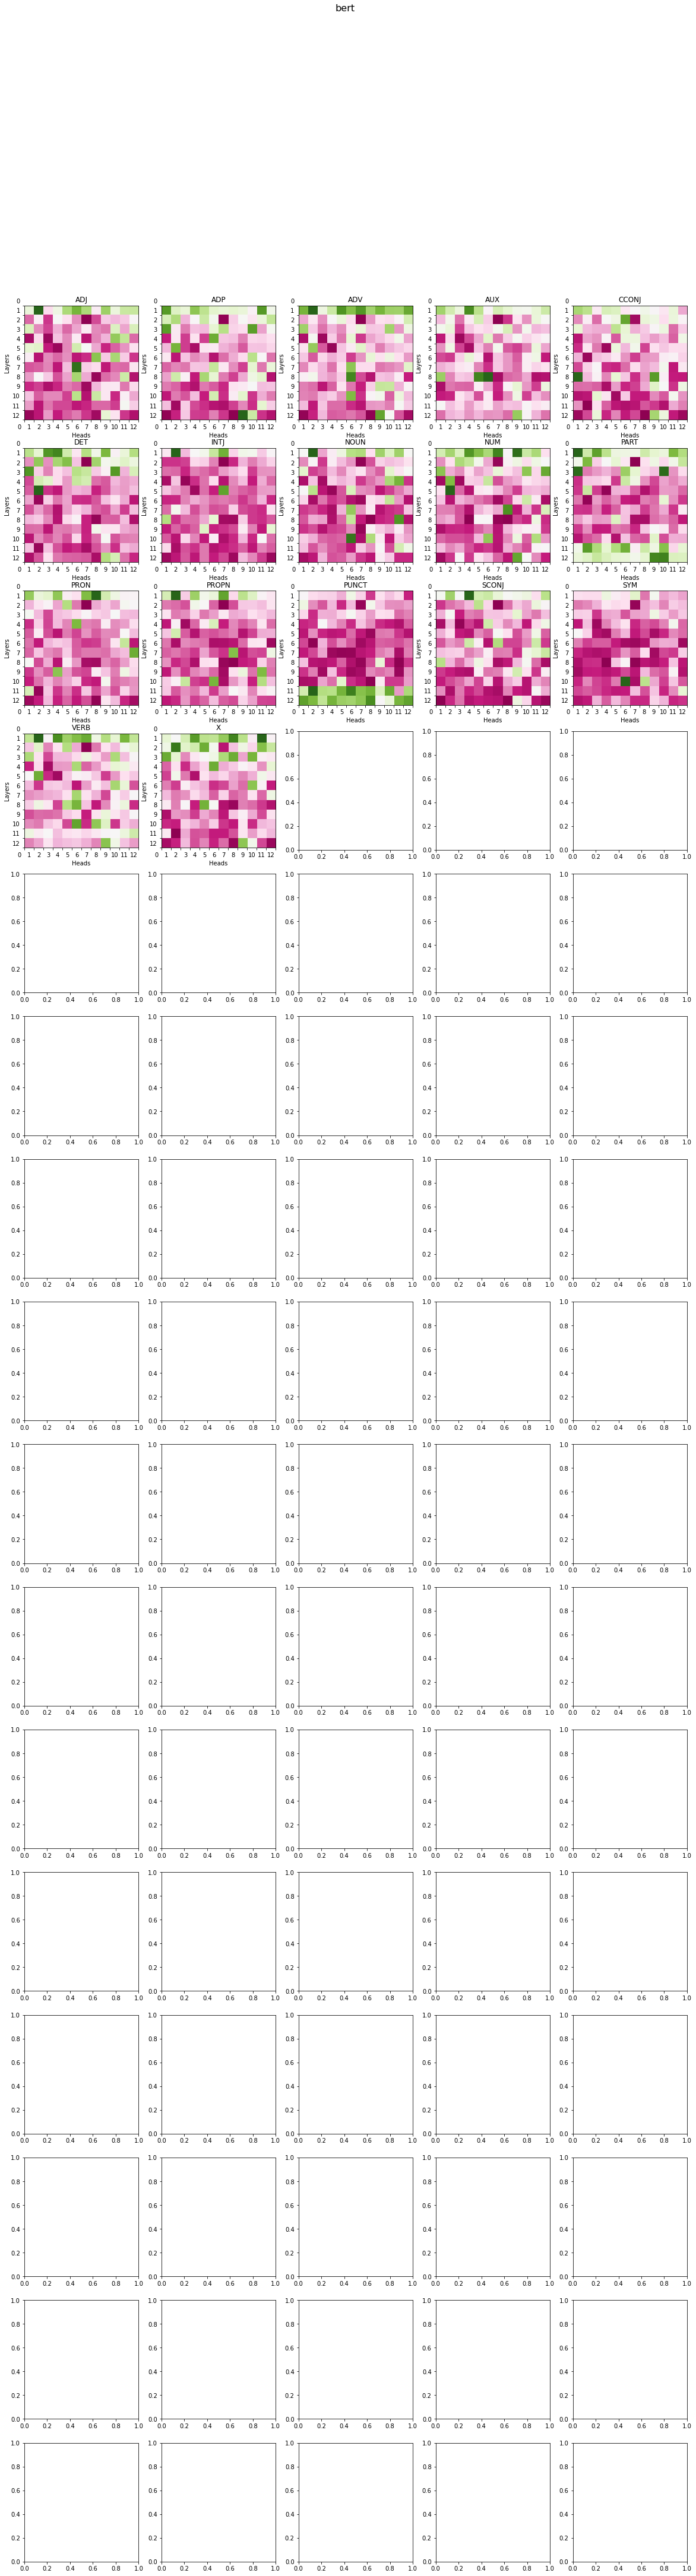

In [113]:
model = list(avg_attention_dicts.keys())[0]
plot_avg_matrices(avg_attention_dicts[model], model)

In [117]:
def plot_distrib_difference(attn_dict1, attn_dict2, model_name = 'bert'):
    #magenta -> negativo
    #verde -> positivo
    #bianco -> 0
    n_elem = (10 * (int(len(special_tkns)/10) + 1)) if len(special_tkns)%10 !=0 else (10 * (int(len(special_tkns)/10)))
    n_row = int(n_elem/5)
    n_col = 5
    fig, ax = plt.subplots(n_row, n_col, figsize=(20,70))
    plt.set_cmap('PiYG')
    fig.suptitle(model_name, fontsize=16)
    
    I, J = np.unravel_index(np.arange(n_elem), shape = (n_row, n_col))
    for k, t in enumerate(special_tkns):
        i, j = I[k], J[k]
        ax[i][j].set_title(f"{t}")
        ax[i][j].set_xlabel("Heads")
        ax[i][j].set_ylabel("Layers")
        ax[i][j].set_xticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        ax[i][j].set_yticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
        # apply offset transform to all x ticklabels.
        # Create offset transform by 5 points in x direction
        dx = -8/72.; dy = 0/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].xaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        
        dx = 0/72.; dy = 8/72. 
        offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
        for label in ax[i][j].yaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)
        mat = np.zeros((12,12))
        
        a1 = [[[] for _ in np.arange(12)] for _ in np.arange(12)]
        for item in attn_dict1[model_name][t]:
            for l in np.arange(12):
                for h in np.arange(12):
                    a1[l][h].append(item[l][h])
        
        a2 = [[[] for _ in np.arange(12)] for _ in np.arange(12)]
        for item in attn_dict2[model_name][t]:
            for l in np.arange(12):
                for h in np.arange(12):
                    a2[l][h].append(item[l][h])
        for l in np.arange(12):
            for h in np.arange(12):
                p = ks_2samp(a1[l][h], a2[l][h]).pvalue
                mat[l][h] = -1 if p < 0.001 else 1
        ax[i][j].imshow(mat)
        

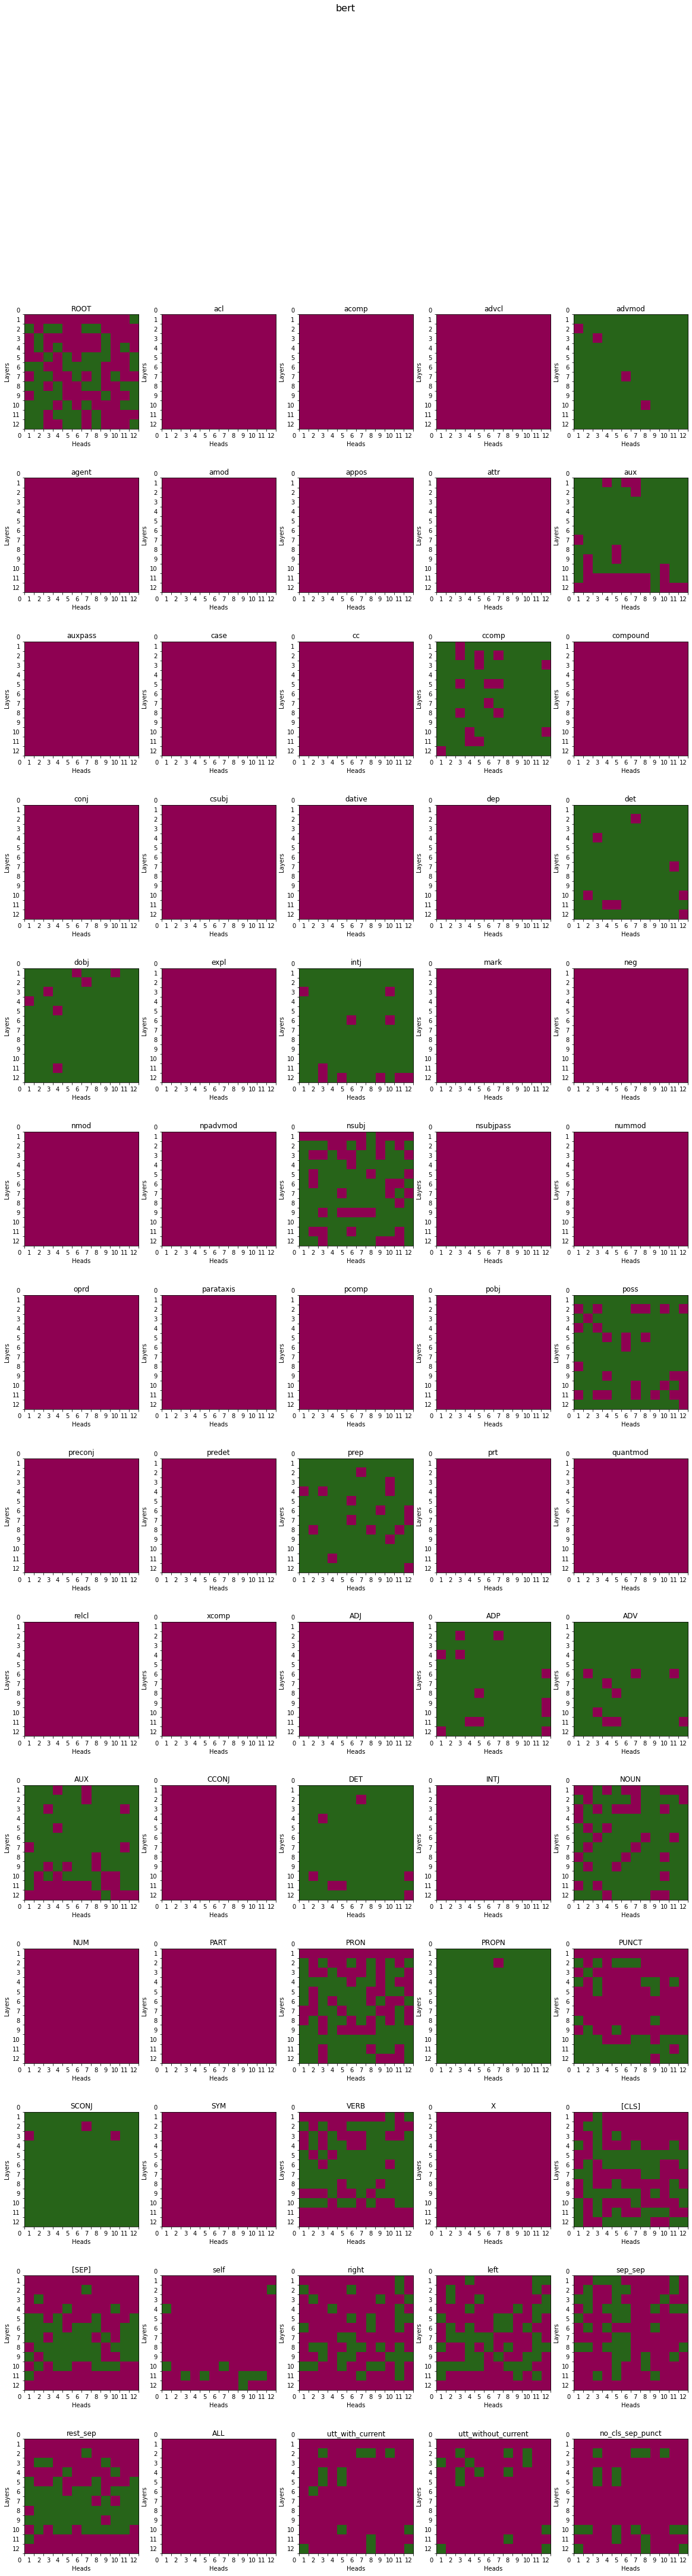

In [118]:
plot_distrib_difference(distrib_attention_dicts, distrib_attention_not_coherent_dicts)

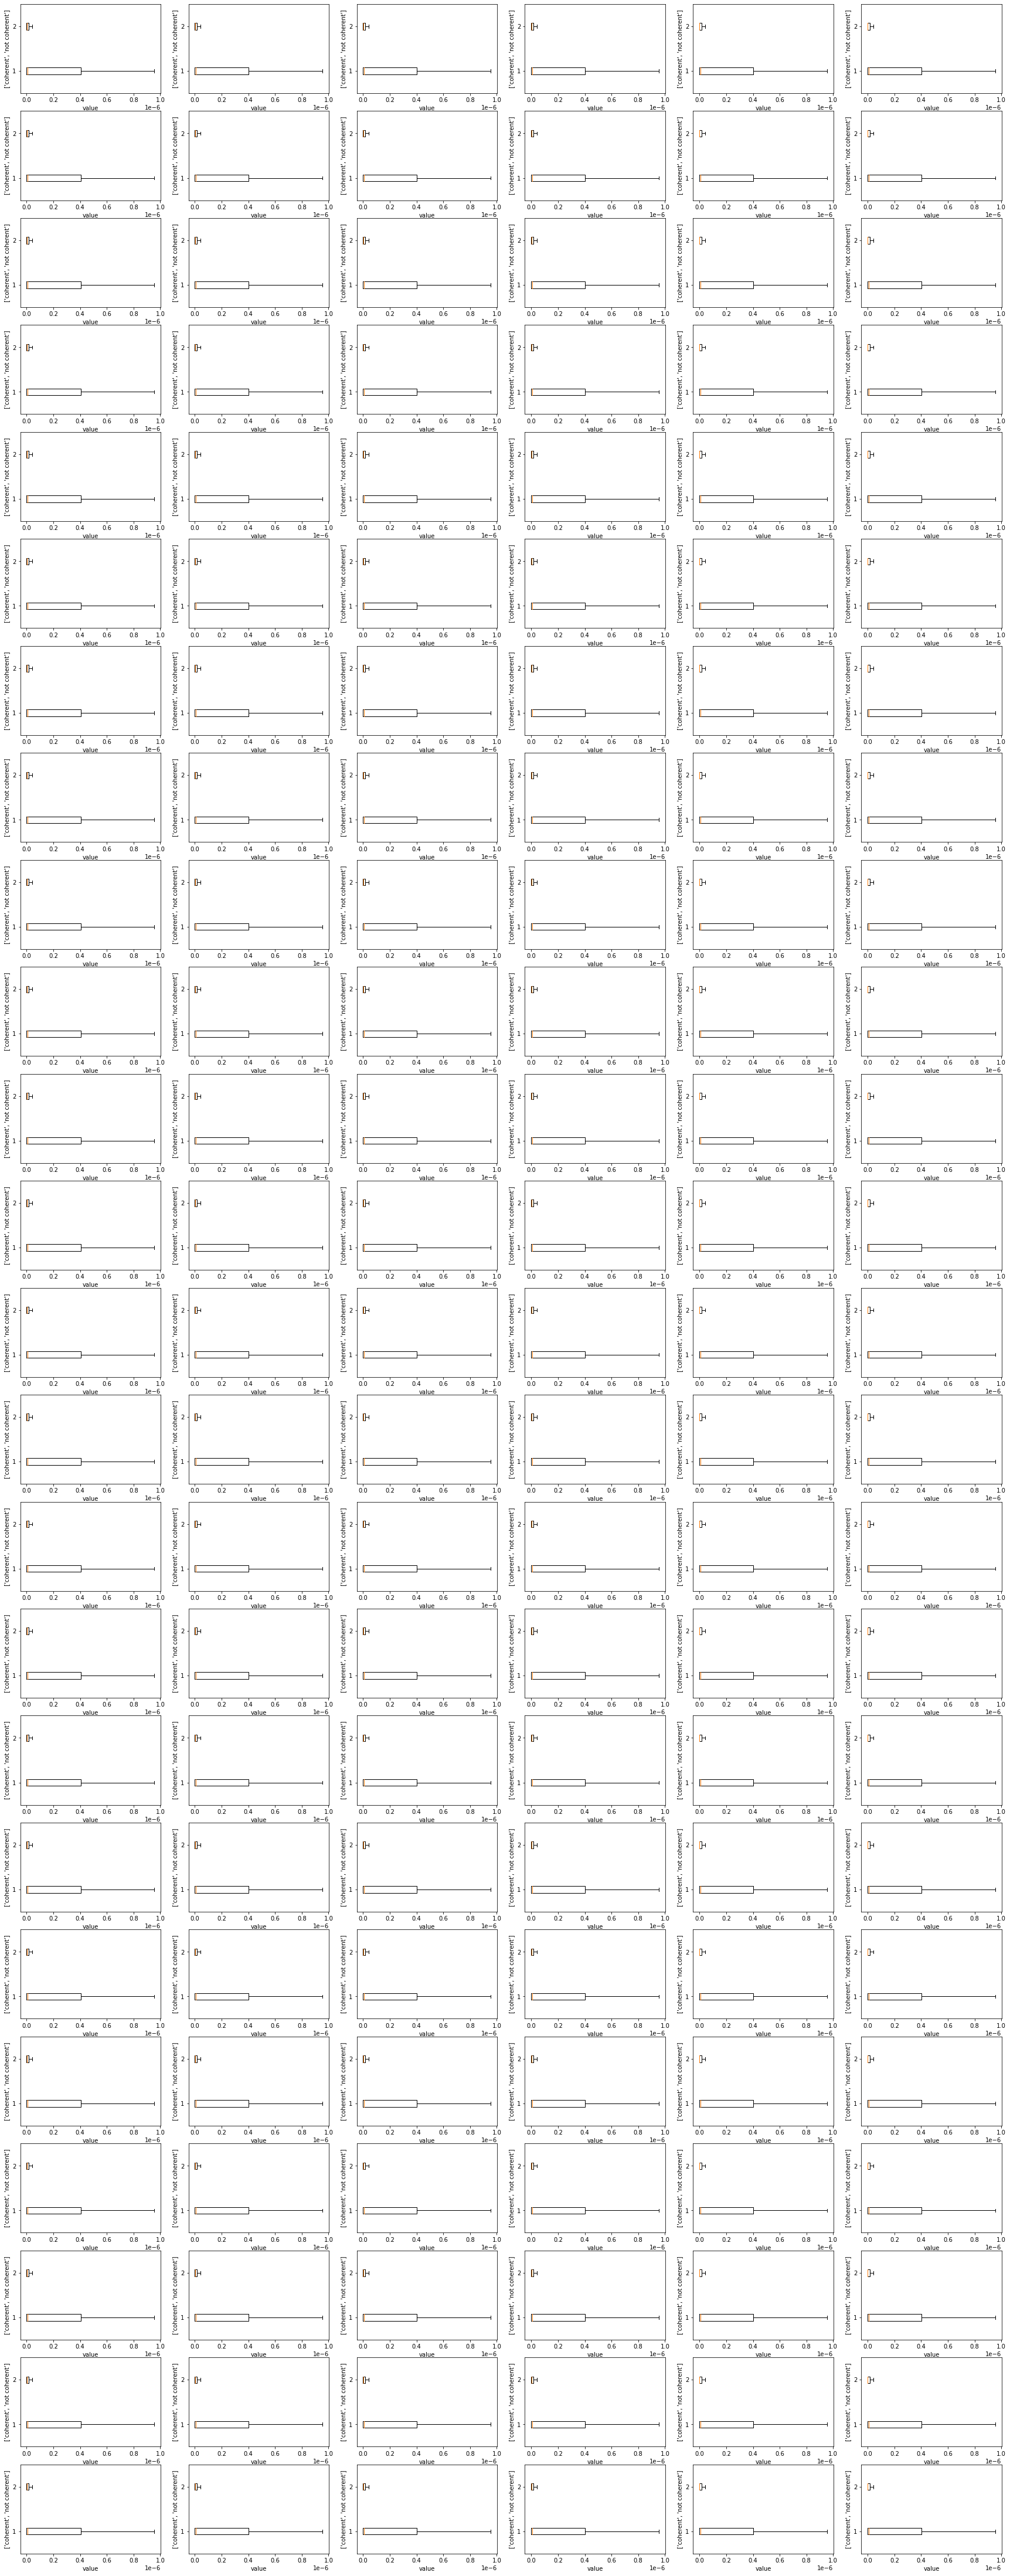

In [723]:
fig, ax = plt.subplots(int(144/6), 6, figsize=(30,80))
I, J = np.unravel_index(np.arange(12*12), shape = (int(144/6), 6))

elem = 0
for l in np.arange(12):
    for h in np.arange(12):
        i, j = I[elem], J[elem]

        a1 = [[[] for _ in np.arange(12)] for _ in np.arange(12)]
        for item in distrib_attention_dicts['bert']['ALL']:
            for l in np.arange(12):
                for h in np.arange(12):
                    a1[l][h].append(item[l][h] ** 5)
        
        a2 = [[[] for _ in np.arange(12)] for _ in np.arange(12)]
        for item in distrib_attention_not_coherent_dicts['bert']['ALL']:
            for l in np.arange(12):
                for h in np.arange(12):
                    a2[l][h].append(item[l][h] ** 5)
                    
        ax[i][j].boxplot([a1[l][h], a2[l][h]], vert=False, manage_ticks=True, showfliers=False)
        ax[i][j].set_xlabel('value')
        ax[i][j].set_ylabel(['coherent', 'not coherent'])

        elem += 1

## First coherence metric

##### By learned models

In [747]:
def featurize (distr_attn_d, coherent):
    df = pd.DataFrame(columns = [(i, j) for i in np.arange(12) for j in np.arange(12)]+['y'])
    for item in distr_attn_d['ALL']:
        data = {(i, j): [item[i][j]] for i in np.arange(12) for j in np.arange(12)}
        data['y'] = coherent
        new = pd.DataFrame.from_dict(data = data)
        df = pd.concat([df, new])
    return df

In [748]:
d_final = pd.concat([featurize(distrib_attention_dicts['bert'], 1), featurize(distrib_attention_not_coherent_dicts['bert'], 0)])

In [505]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [751]:
shuffled = d_final.sample(frac=1,random_state=1)
X = shuffled.iloc[:, 1:144]

standardizer = StandardScaler()
X = standardizer.fit_transform(X)
y = shuffled.iloc[:, -1]
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=0)

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_train, y_train)
    
    # Prediction 
    predictions = models[key].predict(X_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

/Users/lizzy/Desktop/Universita/tesi/git/dialogue_coherence/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [752]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

In [753]:
df_model

,Accuracy,Precision,Recall
Logistic Regression,0.593333,0.441176,0.566038
Support Vector Machines,0.600000,0.441176,0.576923
Decision Trees,0.473333,0.352941,0.406780
Random Forest,0.460000,0.397059,0.402985
Naive Bayes,0.573333,0.264706,0.562500
K-Nearest Neighbor,0.506667,0.470588,0.457143


##### Distributions - not used

By looking at distributions: Computing the probability of a point to belong to a distribution means computing the value of a probability density function in a certain interval.

In [754]:
def estimate_distributions(attn_dicts):
    kdes = {k:[[None for _ in np.arange(12)] for _ in np.arange(12)] for k in attn_dicts.keys()}
    for m in attn_dicts.keys():
        for l in tqdm(np.arange(12)):
            for h in np.arange(12):
                data = np.array([item[l][h] for item in attn_dicts[m]['ALL']])[:, np.newaxis]
                kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian', 'linear', 'tophat']
                h_vals = np.arange(0.05, 1, .1)
                def my_scores(estimator, X):
                    scores = estimator.score_samples(X)
                    # Remove -inf
                    scores = scores[scores != float('-inf')]
                    # Return the mean values
                    return np.mean(scores)

                grid = GridSearchCV(KernelDensity(),
                                    {'bandwidth': h_vals, 'kernel': kernels},
                                    scoring=my_scores)
                grid.fit(data)
                best_kde = grid.best_estimator_
                kdes[m][l][h] = best_kde
    return kdes

In [755]:
def coherence_metric(kernel_dens, example):
    likelihood = {k: [{'tot_likelihood' : 0,
        'layer_head_likelihood':[[0 for _ in np.arange(12)] for _ in np.arange(12)]} for _ in np.arange(len(example[k]['no_cls_sep_punct']))] for k in example.keys()}
    for m in example.keys():
        i = 0
        for item in tqdm(example[m]['ALL']):
            for l in np.arange(np.shape(item)[0]):
                for h in np.arange(np.shape(item)[1]):
                    data = item[l][h].reshape(-1,1)
                    s = kernel_dens[m][l][h].score_samples(data)
                    likelihood[m][i]['layer_head_likelihood'][l][h] = s
                    likelihood[m][i]['tot_likelihood'] += np.sum(s)
            i += 1
                
    return likelihood

In [756]:
kernel_densities = estimate_distributions(distrib_attention_dicts)

100%|██████████| 12/12 [00:44<00:00,  3.74s/it]


In [757]:
l1 = coherence_metric(kernel_densities, distrib_attention_not_coherent_dicts)

100%|██████████| 300/300 [00:03<00:00, 88.97it/s]


In [758]:
np.sum([item['tot_likelihood'] for item in l1['bert']])

104044.5584147029

In [759]:
l2 = coherence_metric(kernel_densities, distrib_attention_dicts)

100%|██████████| 300/300 [00:03<00:00, 89.74it/s]


In [760]:
np.sum([item['tot_likelihood'] for item in l2['bert']])

97718.5369485977

{'whiskers': [<matplotlib.lines.Line2D at 0x45cc045e0>,
 'caps': [<matplotlib.lines.Line2D at 0x45cc048b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x610464760>,
 'medians': [<matplotlib.lines.Line2D at 0x460410a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x4604107f0>,
 'means': []}

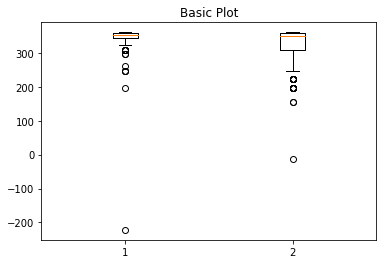

In [761]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot([[item['tot_likelihood'] for item in l1['bert']], [item['tot_likelihood'] for item in l2['bert']]])

##### Neural network - not used

In [762]:
%load_ext tensorboard
import tensorflow as tf
import datetime
# Clear any logs from previous runs
!! rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


[]

In [763]:
y = [1] * len(distrib_attention_dicts['bert']['ALL']) + [0] * len(distrib_attention_dicts['bert']['ALL'])
x = distrib_attention_dicts['bert']['ALL'] + distrib_attention_dicts['bert']['ALL']
c = list(zip(x, y))
random.shuffle(c)
X, y = zip(*c)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.30, random_state=0)

In [764]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(12, 12)),
    tf.keras.layers.Dense(144, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')
  ])

In [765]:
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

In [766]:
model = tf.keras.models.Sequential()
model.add(Conv1D(filters=12, kernel_size=4, strides = 1, padding='same', activation='relu', input_shape=(12, 12,)))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(144, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='softmax'))

In [767]:
model = create_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=X_train, 
          y=y_train, 
          epochs=100, 
          validation_data=(X_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/100


2022-06-18 09:46:44.513524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.4810

2022-06-18 09:46:45.848419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 50ms/step - loss: 0.6943 - accuracy: 0.4810 - val_loss: 0.6974 - val_accuracy: 0.5444
Epoch 2/100
14/14 [==============================] - 0s 26ms/step - loss: 0.6929 - accuracy: 0.4810 - val_loss: 0.6949 - val_accuracy: 0.5444
Epoch 3/100
14/14 [==============================] - 0s 24ms/step - loss: 0.6928 - accuracy: 0.4810 - val_loss: 0.6937 - val_accuracy: 0.5444
Epoch 4/100
14/14 [==============================] - 0s 23ms/step - loss: 0.6949 - accuracy: 0.4810 - val_loss: 0.6969 - val_accuracy: 0.5444
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6935 - accuracy: 0.4810 - val_loss: 0.6956 - val_accuracy: 0.5444
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6931 - accuracy: 0.4810 - val_loss: 0.6983 - val_accuracy: 0.5444
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6934 - accuracy: 0.4810 - val_loss: 0.6955 - val_accuracy: 0.5444
Epoch 8/100
14/14 

In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 47276), started 0:00:21 ago. (Use '!kill 47276' to kill it.)

#### Distance to means

In [768]:
d_c = [[[] for _ in np.arange(12)] for _ in np.arange(12)]
for item in distrib_attention_dicts[k]['ALL']:
    for l in np.arange(12):
        for h in np.arange(12):
            d_c[l][h].append(item[l][h] ** 5)

d_notc = [[[] for _ in np.arange(12)] for _ in np.arange(12)]
for item in distrib_attention_not_coherent_dicts[k]['ALL']:
    for l in np.arange(12):
        for h in np.arange(12):
            d_notc[l][h].append(item[l][h] ** 5)

In [769]:
medians_c = [[np.quantile(d_c[l][h], 0.5) for h in np.arange(12)] for l in np.arange(12)]
medians_notc = [[np.quantile(d_notc[l][h], 0.6) for h in np.arange(12)] for l in np.arange(12)]

In [782]:
def coherence_metric(example):
    for tokens, attns, _, _, _, _, _, _, _, pos_aligned  in data_iterator_no_print(example):
        n_tokens = tf.shape(attns)[-1]
        total_attn = (
        (attns).sum(-1).sum(-1) / n_tokens ** 2) ** 5        
        
    return statistics.mode((np.array(total_attn) < medians_notc).flatten())  

In [783]:
def coherence_metric_f(example):
    for tokens, attns, _, _, _, _, _, _, _, pos_aligned  in data_iterator_no_print(example):
        n_tokens = tf.shape(attns)[-1]
        
        # no cls, sep and punct filter
        mask_no_cls_sep_punct = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
              mask_no_cls_sep_punct[v][w] = 1 if pos_aligned[v] != 'PUNCT' and tokens[v] not in ['[SEP]', '[CLS]'] else 0
        
        selectors = {
          "no_cls_sep_punct": mask_no_cls_sep_punct
        }
        
        # get the average attention for each token type
        for key, selector in selectors.items():
          denom = selector.sum(-1).sum(-1)
          if denom == 0:
            denom = 1
          total_attn = (
            (attns * selector[np.newaxis, np.newaxis]).sum(-1).sum(-1) / denom) ** 5        
        
    return statistics.mode((total_attn < medians_notc).flatten())  

In [784]:
def data_iterator_no_print(data):
  for i, doc in enumerate(data):
    yield doc["tokens"], np.array(doc["attns"]), doc["words"], doc["relns"], doc["heads"], doc["pos"], doc["relns_aligned"], doc["words_aligned"], doc["heads_aligned"], doc["pos_aligned"]
    

loss_not_coherent = 0
for item in tqdm(attention_dicts_not_coherent['bert']):
    loss_not_coherent += 0 if coherence_metric([item]) else 1
    
loss_coherent = 0
for item in tqdm(attention_dicts['bert']):
    loss_coherent += 1 if coherence_metric([item]) else 0
    
print(f"Not coherent loss: {loss_not_coherent/len(attention_dicts_not_coherent['bert'])}")
print(f"Coherent loss: {loss_coherent/len(attention_dicts['bert'])}")

100%|██████████| 300/300 [00:01<00:00, 160.03it/s]

Not coherent loss: 0.39
Coherent loss: 0.43333333333333335


## Attention selection

### Getting 90th quantile - last quantile values

In [7]:
#rilevanti se dalla mediana all'ultimo quantile
relevance_quantiles = {
    k: [[[0, 0] for _ in np.arange(12)] for _ in np.arange(12)] for k in pointwise_distrib_attention_dicts
}

for k in relevance_quantiles:
    for l in np.arange(12):
        for h in np.arange(12):
            relevance_quantiles[k][l][h][0] = np.max(pointwise_distrib_attention_dicts[k][l][h]['lower'])
            relevance_quantiles[k][l][h][1] = np.max(pointwise_distrib_attention_dicts[k][l][h]['upper'])

In [454]:
def select_attn(attn_dict, rel_q):  
  attn_selected = attn_dict.copy()
  
  for k in attn_dict:      
      print("Selecting weights")
      for i, item in enumerate(attn_dict[k]):
        print(f'{np.round(i/len(attn_dict[k]),4)*100}', end='\r')
        n_tokens = int(tf.shape(item['attns'])[-1])
        att_mat = [[[[0 for _ in np.arange(n_tokens)] for _ in np.arange(n_tokens)] for _ in np.arange(12)] for _ in np.arange(12)]
        for l in np.arange(12):
            for h in np.arange(12):
              m1 = item['attns'][l][h] >= rel_q[k][l][h][0]
              m2 = item['attns'][l][h] <= rel_q[k][l][h][1]
              m = m1 * m2
              att_mat[l][h] = item['attns'][l][h] * m
        attn_selected[k][i]['attn_selected'] = att_mat
  return attn_selected


In [340]:
attention_selected = select_attn(attention_dicts, relevance_quantiles)

Selecting weights
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-19 10:57:58.889212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-19 10:57:58.891001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [457]:
attention_selected_not_coherent = select_attn(attention_dicts_not_coherent, relevance_quantiles)

Selecting weights


In [455]:
relevance_quantiles['bert'][0][0][0]

0.03827232234179974

In [456]:
relevance_quantiles['bert'][0][0][1]

0.4928663671016693

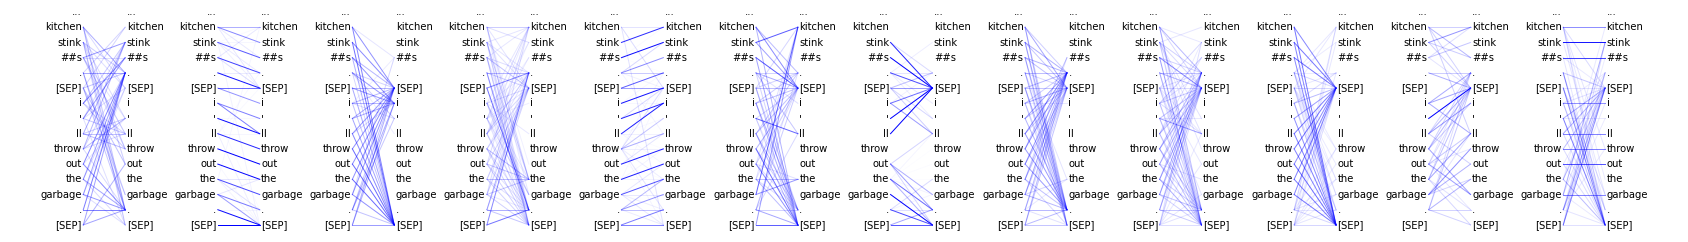

In [344]:
width = 3
example_sep = 3
word_height = 1
pad = 0.1


def plot_attn(example, heads):
  """Plots attention maps for the given example and attention heads."""

  for ei, (layer, head) in enumerate(heads):
    yoffset = 1
    xoffset = ei * width * example_sep

    attn = example["attn_selected"][layer][head][-15:, -15:]
    attn = np.array(attn)
    attn /= (attn.sum(axis=-1, keepdims=True)+0.00000000001)
    words = example["tokens"][-15:]
    words[0] = "..."
    n_words = len(words)

    for position, word in enumerate(words):
      plt.text(xoffset + 0, yoffset - position * word_height, word,
               ha="right", va="center")
      plt.text(xoffset + width, yoffset - position * word_height, word,
               ha="left", va="center")
    for i in range(1, n_words):
      for j in range(1, n_words):
        if not math.isnan(attn[i, j]):
          plt.plot([xoffset + pad, xoffset + width - pad],
                  [yoffset - word_height * i, yoffset - word_height * j],
                  color="blue", linewidth=1, alpha=attn[i, j])

plt.figure(figsize=(30, 4))
plt.axis("off")
plot_attn(attention_selected['bert'][0], [(1, j) for j in np.arange(12)])
plt.show()

## Networkx graph

In [8]:
def make_graph(example, layer, head):
    G = nx.DiGraph()
    w = 1
    tot_utt = example['tokens'].count("[SEP]")
    u = tot_utt
    
    for i, t in enumerate(example['tokens']):
        G.add_node(i, pos = (w, u - (0.1 * w)))
        G.nodes[i]['part_of_speech'] = example['pos_aligned'][i]
        G.nodes[i]['dependency_relation'] = example['relns_aligned'][i]  
        G.nodes[i]['utterance'] = tot_utt - u
        G.nodes[i]['label'] = t
        w += 1
        if t == "[SEP]": 
            u -= 1
            w = 1
    
    G.add_edges_from([(i, j, {'weight': example['attns'][layer][head][i][j]}) for j in np.arange(len(example['tokens'])) for i in np.arange(len(example['tokens'])) if example['attns'][1][2][i][j] != 0])
    return G

In [9]:
def plt_graph(graph):
    tot_utt = [graph.nodes[node]['label'] for node in graph.nodes].count("[SEP]")
    max_len = []
    w = 1
    for node in graph.nodes:
        w += 1
        if graph.nodes[node]['label'] == "[SEP]": 
            max_len.append(w)
            w = 1
    pos = nx.get_node_attributes(graph,'pos')
    
    in_degrees = {k: dict(graph.in_degree)[k] for k in dict(graph.in_degree)}
    
    plt.figure(1,figsize=(max(max_len), tot_utt * 2)) 
    
    nx.draw_networkx_nodes(graph, pos, node_color = 'r', node_size = 100, alpha = 1)
    ax = plt.gca()
    for i, e in enumerate(graph.edges):
        ax.annotate("",
                    xy=pos[e[0]], xycoords='data',
                    xytext=pos[e[1]], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color="black",
                                    lw = graph.edges[e]['weight'],
                                    shrinkA=5, shrinkB=5,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(0.01*in_degrees[e[1]])
                                    ),
                                    ),
                    )
        in_degrees[e[1]] = in_degrees[e[1]] - 1
    plt.axis('off')
    
    for i, t in nx.get_node_attributes(graph,'label').items():
        x,y=pos[i]
        plt.text(x,y+0.1,s=t, bbox=dict(facecolor='red', alpha=0.7), horizontalalignment='center')

    plt.show()

In [10]:
def filtering_graph_and_plot(ex, layer= 1, head = 2, plot = False, filters = None, min_attention = None, max_attention = None, tokens_to_avoid = None, pos_to_avoid = None, deps_to_avoid = None, tokens_to_include = None, pos_to_include = None, deps_to_include = None):
    n_tokens = len(ex['tokens'])
    new_ex = deepcopy(ex)
    if filters == "no_cls_sep_punct":
        filter = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
              filter[v][w] = 1 if (ex['pos_aligned'][w] != 'PUNCT' and ex['tokens'][w] not in ['[SEP]', '[CLS]']
              and ex['pos_aligned'][v] != 'PUNCT' and ex['tokens'][v] not in ['[SEP]', '[CLS]']) else 0
        new_ex['attns'] *= filter
    
    elif filters == "utt_mask_with_current":
        sep_positions = [i for i, item in enumerate(ex['tokens']) if item in ['[CLS]', '[SEP]']]
        utt_masks_with_current = []
        total_attn = np.zeros(shape = (12, 12, n_tokens, n_tokens))
        for i in np.arange(len(sep_positions)-1):
          mask_with_current = np.zeros(shape = (n_tokens, n_tokens))
          for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
              mask_with_current[v][w] = 1 if (((v >= sep_positions[i] and v <= sep_positions[i+1]) or (w >= sep_positions[i] and w <= sep_positions[i+1]))
                                   and ex['pos_aligned'][w] != 'PUNCT' and ex['tokens'][w] not in ['[SEP]', '[CLS]']
                                   and ex['pos_aligned'][v] != 'PUNCT' and ex['tokens'][v] not in ['[SEP]', '[CLS]']) else 0
          utt_masks_with_current.append(mask_with_current)
          total_attn += ex['attns'] * mask_with_current / (ex['tokens'].count("[SEP]"))
        new_ex['attns'] = total_attn
          
    elif filters == "utt_mask_without_current":
        sep_positions = [i for i, item in enumerate(ex['tokens']) if item in ['[CLS]', '[SEP]']]
        utt_masks_without_current = []
        total_attn = np.zeros(shape = (12, 12, n_tokens, n_tokens))
        for i in np.arange(len(sep_positions)-1):
            mask_without_current = np.zeros(shape = (n_tokens, n_tokens))
            for v in np.arange(n_tokens):
                for w in np.arange(n_tokens):
                    mask_without_current[v][w] = 1 if ((v >= sep_positions[i] and v <= sep_positions[i+1]) != (w >= sep_positions[i] and w <= sep_positions[i+1]) 
                                   and ex['pos_aligned'][w] != 'PUNCT' and ex['tokens'][w] not in ['[SEP]', '[CLS]']
                                   and ex['pos_aligned'][v] != 'PUNCT' and ex['tokens'][v] not in ['[SEP]', '[CLS]']) else 0
            utt_masks_without_current.append(mask_without_current)
            total_attn += ex['attns'] * mask_without_current / (ex['tokens'].count("[SEP]"))
        new_ex['attns'] = total_attn
    
    if tokens_to_avoid != None:
        filter = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
                filter[v][w] = 1 if (ex['tokens'][w] not in tokens_to_avoid
                                and ex['tokens'][v] not in tokens_to_avoid) else 0
        new_ex['attns'] *= filter
    
    if pos_to_avoid != None:
        filter = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
                filter[v][w] = 1 if (ex['pos_aligned'][w] not in pos_to_avoid
                                and ex['pos_aligned'][v] not in pos_to_avoid) else 0
        new_ex['attns'] *= filter
        
    if deps_to_avoid != None:
        filter = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
                filter[v][w] = 1 if (ex['relns_aligned'][w] not in deps_to_avoid
                                and ex['relns_aligned'][v] not in deps_to_avoid) else 0
        new_ex['attns'] *= filter
        
    if tokens_to_include != None:
        filter = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
                filter[v][w] = 1 if (ex['tokens'][w] in tokens_to_include
                                and ex['tokens'][v] in tokens_to_include) else 0
        new_ex['attns'] *= filter
        
    if pos_to_include != None:
        filter = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
                filter[v][w] = 1 if (ex['pos_aligned'][w] in pos_to_include
                                and ex['pos_aligned'][v] in pos_to_include) else 0
        new_ex['attns'] *= filter
        
    if deps_to_include != None:
        filter = np.zeros(shape = (n_tokens, n_tokens))
        for v in np.arange(n_tokens):
            for w in np.arange(n_tokens):
                filter[v][w] = 1 if (ex['relns_aligned'][w] in deps_to_include
                                and ex['relns_aligned'][v] in deps_to_include) else 0
        new_ex['attns'] *= filter
    
    new_ex['attns'] = new_ex['attns'] * (new_ex['attns'] > min_attention) if min_attention != None else new_ex['attns']
    new_ex['attns'] = new_ex['attns'] * (new_ex['attns'] < max_attention) if max_attention != None else new_ex['attns']
    G = make_graph(new_ex, layer, head)
    if plot: plt_graph(G)
    return G

In [11]:
relevance_quantiles['bert'][1][2][0]

0.2628748118877411

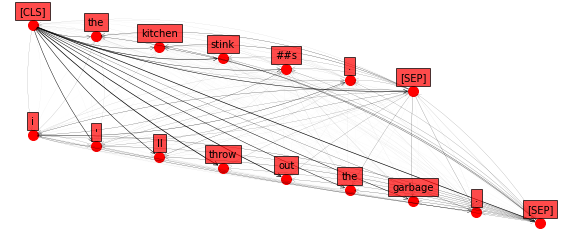

In [95]:
G = filtering_graph_and_plot(attention_dicts['bert'][0],  layer= 1, head = 2, plot = True)

### Path extraction

In [13]:
def extract_paths(dialogue_graph):
    all_paths = []
    for i in np.arange(len(dialogue_graph.nodes)):
        for j in np.arange(len(dialogue_graph.nodes)):
            if dialogue_graph.nodes[i]['utterance'] != dialogue_graph.nodes[j]['utterance']:
                paths = nx.alln_simple_paths(dialogue_graph, source=i, target=j)
                for path in paths:
                    w, d, p = [], [], []
                    for node in path:
                        w.append(dialogue_graph.nodes[node]['label'])
                        d.append(dialogue_graph.nodes[node]['dependency_relation'])
                        p.append(dialogue_graph.nodes[node]['part_of_speech'])
                    all_paths.append({
                            'path': path,
                            'words': w,
                            'dependency_relations': d,
                            'part_of_speech': p
                        })
    return all_paths

In [17]:
def analyse_paths(dialogues_paths):
    path_analysis = {'avg_path_length':[],
                    'number_of_paths':[],
                    'perc_special_tkn_selected':[],
                    'perc_non_relevant':[]}
    perc_pos = {f'perc_{k}':[] for k in pos_keys}
    perc_deps = {f'perc_{k}':[] for k in dep_keys}
    path_analysis = path_analysis | perc_pos | perc_deps
    for dialogue_paths in dialogues_paths:
        if dialogue_paths == []: continue
        n_paths = len(dialogue_paths)
        p_len, p_non_rel, p_special_tkn_sel, p_non_rel = [[] for _ in np.arange(4)]
        p_pos = {k:[] for k in pos_keys}
        p_dep = {k:[] for k in dep_keys}
        for path in dialogue_paths:
            p_length = len(path['path'])
            p_len.append(p_length)
            p_special_tkn_sel.append((path['words'].count('[SEP]') + path['words'].count('[CLS]')) / (p_length))
            [p_pos[k].append(path['part_of_speech'].count(k)/p_length) for k in pos_keys if k not in ['[CLS]', '[SEP]']]
            [p_dep[k].append(path['dependency_relations'].count(k)/p_length) for k in dep_keys]
            p_non_rel.append(((path['words'].count('[SEP]') + path['words'].count('[CLS]')) + path['part_of_speech'].count('PUNCT')) / p_length)
        path_analysis['avg_path_length'].append(np.sum(p_len)/(n_paths))
        path_analysis['number_of_paths'].append((n_paths))
        path_analysis['perc_special_tkn_selected'].append(np.sum(p_special_tkn_sel)/(n_paths))
        path_analysis['perc_non_relevant'].append(np.sum(p_non_rel)/(n_paths))
        [path_analysis[f'perc_{k}'].append(np.sum(p_pos[k])/(n_paths)) for k in pos_keys if k not in ['[CLS]', '[SEP]']]
        [path_analysis[f'perc_{k}'].append(np.sum(p_dep[k])/(n_paths)) for k in dep_keys]
    return path_analysis

#### Iterate over all dataset (with attention selected)

In [96]:
all_analysis = analyse_paths([extract_paths(filtering_graph_and_plot(item, layer= 0, head = 0, min_attention = relevance_quantiles['bert'][0][0][0], filters="no_cls_sep_punct")) for item in tqdm(attention_dicts['bert'])])

100%|██████████| 300/300 [00:13<00:00, 22.96it/s]


In [97]:
all_analysis_not_coherent = analyse_paths([extract_paths(filtering_graph_and_plot(item, layer= 0, head = 0, min_attention = relevance_quantiles['bert'][0][0][0], filters="no_cls_sep_punct")) for item in tqdm(attention_dicts_not_coherent['bert'])])

100%|██████████| 300/300 [00:15<00:00, 18.92it/s]


### Path description

In [123]:
descr_coherent = {k: np.mean(all_analysis[k]) for k in all_analysis}
descr_coherent

{'avg_path_length': 2.0,
 'number_of_paths': 1.4705882352941178,
 'perc_special_tkn_selected': 0.0,
 'perc_non_relevant': 0.0,
 'perc_ADJ': 0.029411764705882353,
 'perc_ADP': 0.029411764705882353,
 'perc_ADV': 0.04411764705882353,
 'perc_AUX': 0.04411764705882353,
 'perc_CCONJ': 0.0,
 'perc_DET': 0.029411764705882353,
 'perc_INTJ': 0.0,
 'perc_NOUN': 0.3088235294117647,
 'perc_NUM': 0.04411764705882353,
 'perc_PART': 0.0,
 'perc_PRON': 0.29411764705882354,
 'perc_PROPN': 0.029411764705882353,
 'perc_PUNCT': 0.0,
 'perc_SCONJ': 0.0,
 'perc_SYM': 0.0,
 'perc_VERB': 0.10294117647058823,
 'perc_X': 0.04411764705882353,
 'perc_[CLS]': 0.0,
 'perc_[SEP]': 0.0,
 'perc_ROOT': 0.18382352941176472,
 'perc_acl': 0.0,
 'perc_acomp': 0.0,
 'perc_advcl': 0.0,
 'perc_advmod': 0.014705882352941176,
 'perc_agent': 0.0,
 'perc_amod': 0.029411764705882353,
 'perc_appos': 0.0,
 'perc_attr': 0.00980392156862745,
 'perc_aux': 0.0,
 'perc_auxpass': 0.0,
 'perc_case': 0.0,
 'perc_cc': 0.0,
 'perc_ccomp': 0.0,

In [124]:
descr_not_coherent = {k: np.mean(all_analysis_not_coherent[k]) for k in all_analysis_not_coherent}
descr_not_coherent

{'avg_path_length': 2.0634920634920637,
 'number_of_paths': 1.4285714285714286,
 'perc_special_tkn_selected': 0.0,
 'perc_non_relevant': 0.0,
 'perc_ADJ': 0.06746031746031746,
 'perc_ADP': 0.0,
 'perc_ADV': 0.0,
 'perc_AUX': 0.1044973544973545,
 'perc_CCONJ': 0.0,
 'perc_DET': 0.0,
 'perc_INTJ': 0.0,
 'perc_NOUN': 0.2579365079365079,
 'perc_NUM': 0.09523809523809523,
 'perc_PART': 0.0,
 'perc_PRON': 0.22883597883597884,
 'perc_PROPN': 0.051587301587301584,
 'perc_PUNCT': 0.0,
 'perc_SCONJ': 0.0,
 'perc_SYM': 0.0,
 'perc_VERB': 0.1706349206349206,
 'perc_X': 0.023809523809523808,
 'perc_[CLS]': 0.0,
 'perc_[SEP]': 0.0,
 'perc_ROOT': 0.2037037037037037,
 'perc_acl': 0.0,
 'perc_acomp': 0.01984126984126984,
 'perc_advcl': 0.0,
 'perc_advmod': 0.0,
 'perc_agent': 0.0,
 'perc_amod': 0.047619047619047616,
 'perc_appos': 0.0,
 'perc_attr': 0.0,
 'perc_aux': 0.023809523809523808,
 'perc_auxpass': 0.0,
 'perc_case': 0.0,
 'perc_cc': 0.0,
 'perc_ccomp': 0.047619047619047616,
 'perc_compound': 0.

In [136]:
d = pd.concat([pd.DataFrame([descr_coherent], index = ['coherent']), pd.DataFrame([descr_not_coherent], index = ['non_coherent'])])

In [137]:
d.T

,coherent,non_coherent
avg_path_length,2.000000,2.063492
number_of_paths,1.470588,1.428571
perc_special_tkn_selected,0.000000,0.000000
perc_non_relevant,0.000000,0.000000
perc_ADJ,0.029412,0.067460
perc_ADP,0.029412,0.000000
perc_ADV,0.044118,0.000000
perc_AUX,0.044118,0.104497
perc_CCONJ,0.000000,0.000000
perc_DET,0.029412,0.000000


## Second coherence metric

In [98]:
df = pd.concat([pd.DataFrame(all_analysis_not_coherent | {"y":[0] * len(all_analysis_not_coherent['avg_path_length'])}), pd.DataFrame(all_analysis | {"y":[1] * len(all_analysis['avg_path_length'])})])

In [99]:
df

,avg_path_length,number_of_paths,perc_special_tkn_selected,perc_non_relevant,perc_ADJ,perc_ADP,perc_ADV,perc_AUX,perc_CCONJ,perc_DET,...,perc_poss,perc_preconj,perc_predet,perc_prep,perc_prt,perc_punct,perc_quantmod,perc_relcl,perc_xcomp,y
0,2.000000,3,0.0,0.0,0.000000,0.0,0.166667,0.166667,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0
1,2.000000,1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0
2,2.500000,2,0.0,0.0,0.416667,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0
3,2.000000,1,0.0,0.0,0.000000,0.0,0.000000,0.500000,0.0,0.000000,...,0.500000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0
4,2.000000,1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0
5,2.000000,1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0
6,2.000000,2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0
7,2.000000,1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0
8,2.000000,1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0
9,2.000000,1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.500,0.0,0.0,0.000000,0


In [100]:
models = {}

# Logistic Regression
models['Logistic Regression'] = LogisticRegression()
# Support Vector Machines
models['Support Vector Machines'] = LinearSVC()
# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier()
# Random Forest
models['Random Forest'] = RandomForestClassifier()
models['Naive Bayes'] = GaussianNB()
# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [101]:
shuffled = df.sample(frac=1,random_state=1)
X = shuffled.iloc[:, 0:66]

standardizer = StandardScaler()
X = standardizer.fit_transform(X)
y = shuffled.iloc[:, -1]
y=y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=0)

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_train, y_train)
    
    # Prediction 
    predictions = models[key].predict(X_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

/Users/lizzy/Desktop/Universita/tesi/git/dialogue_coherence/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [102]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

In [103]:
df_model

,Accuracy,Precision,Recall
Logistic Regression,0.586207,0.388889,0.875000
Support Vector Machines,0.620690,0.444444,0.888889
Decision Trees,0.586207,0.444444,0.800000
Random Forest,0.551724,0.333333,0.857143
Naive Bayes,0.620690,0.722222,0.684211
K-Nearest Neighbor,0.586207,0.500000,0.750000


### Check accuracy for different combination of layer and head

In [104]:
dict_models = {'Logistic Regression': LogisticRegression(),
               'Support Vector Machines': LinearSVC(),
               'Decision Trees': DecisionTreeClassifier(),
               'Random Forest': RandomForestClassifier(),
               'Naive Bayes': GaussianNB(),
               'K-Nearest Neighbor': KNeighborsClassifier()}

models = {f'{m} ({l},{h})': dict_models[m] for h in np.arange(12) for l in np.arange(1) for m in ['Logistic Regression', 
                                                                                                'Support Vector Machines',
                                                                                                'Decision Trees',
                                                                                                'Random Forest',
                                                                                                'Naive Bayes',
                                                                                                'K-Nearest Neighbor']}

In [105]:
for l in np.arange(1):
    for h in np.arange(12):
        all_analysis = analyse_paths([extract_paths(filtering_graph_and_plot(item, layer= l, head = h, min_attention = relevance_quantiles['bert'][l][h][0], filters="no_cls_sep_punct")) for item in tqdm(attention_dicts['bert'])])
        all_analysis_not_coherent = analyse_paths([extract_paths(filtering_graph_and_plot(item, layer= l, head = h, min_attention = relevance_quantiles['bert'][l][h][0], filters="no_cls_sep_punct")) for item in tqdm(attention_dicts_not_coherent['bert'])])
        df = pd.concat([pd.DataFrame(all_analysis_not_coherent | {"y":[0] * len(all_analysis_not_coherent['avg_path_length'])}), pd.DataFrame(all_analysis | {"y":[1] * len(all_analysis['avg_path_length'])})])
        shuffled = df.sample(frac=1,random_state=1)
        X = shuffled.iloc[:, 0:66]

        standardizer = StandardScaler()
        X = standardizer.fit_transform(X)
        y = shuffled.iloc[:, -1]
        y=y.astype('int')

        X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=0)

        accuracy, precision, recall = {}, {}, {}

        for key in models.keys():
            
            # Fit the classifier model
            models[key].fit(X_train, y_train)
            
            # Prediction 
            predictions = models[key].predict(X_test)
            
            # Calculate Accuracy, Precision and Recall Metrics
            accuracy[key] = accuracy_score(predictions, y_test)
            precision[key] = precision_score(predictions, y_test)
            recall[key] = recall_score(predictions, y_test)

100%|██████████| 300/300 [00:15<00:00, 19.87it/s]
/Users/lizzy/Desktop/Universita/tesi/git/dialogue_coherence/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lizzy/Desktop/Universita/tesi/git/dialogue_coherence/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lizzy/Desktop/Universita/tesi/git/dialogue_coherence/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lizzy/Desktop/Universita/tesi/git/dialogue_coherence/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/lizzy/Desktop/Universita/tesi/git/dialogue_coherence/ve

In [106]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

In [107]:
pd.set_option('display.max_rows', None)
print(df_model)

                                Accuracy  Precision    Recall
Logistic Regression (0,0)            0.8   0.666667  0.666667
Support Vector Machines (0,0)        0.8   0.666667  0.666667
Decision Trees (0,0)                 0.6   0.666667  0.400000
Random Forest (0,0)                  0.5   0.000000  0.000000
Naive Bayes (0,0)                    0.6   0.000000  0.000000
K-Nearest Neighbor (0,0)             0.6   0.333333  0.333333
Logistic Regression (0,1)            0.8   0.666667  0.666667
Support Vector Machines (0,1)        0.8   0.666667  0.666667
Decision Trees (0,1)                 0.4   0.666667  0.285714
Random Forest (0,1)                  0.5   0.000000  0.000000
Naive Bayes (0,1)                    0.6   0.000000  0.000000
K-Nearest Neighbor (0,1)             0.6   0.333333  0.333333
Logistic Regression (0,2)            0.8   0.666667  0.666667
Support Vector Machines (0,2)        0.8   0.666667  0.666667
Decision Trees (0,2)                 0.3   0.000000  0.000000
Random F

choosing logistic regression

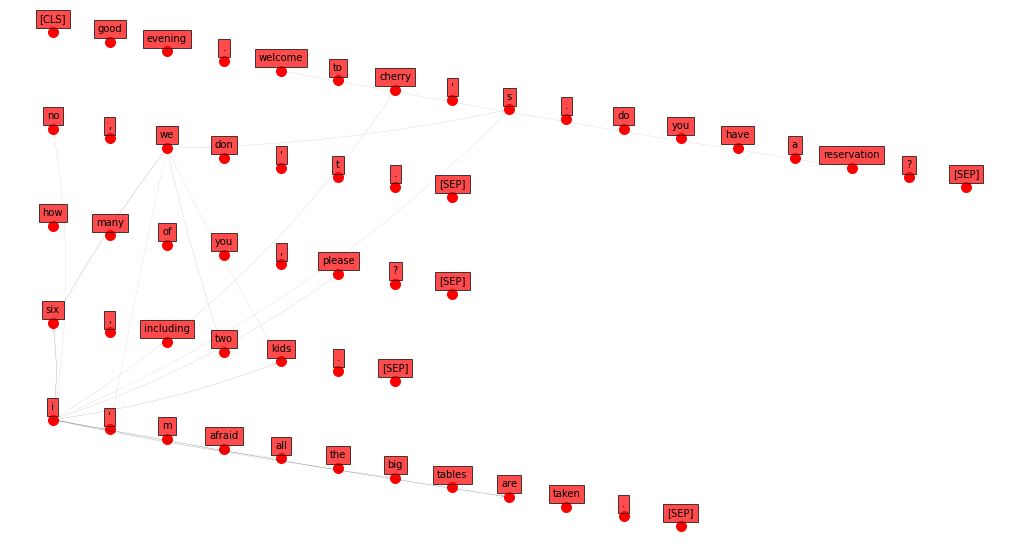

In [76]:
G = filtering_graph_and_plot(attention_dicts['bert'][9], layer= 0, head = 0, min_attention=0.05, filters="no_cls_sep_punct", plot = True)
paths = extract_paths(G)
analyzed_path = analyse_paths([paths])

In [77]:
#example_1 = standardizer.transform(list(analyzed_path.values()))
models["Logistic Regression (0,0)"].predict(standardizer.transform(pd.DataFrame(analyzed_path)))

array([1])